In [1]:
# Import packages
%matplotlib inline
import category_encoders as ce
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [2]:
# Import data
df_trees = pd.read_csv('Data/Intermediate/model_data.csv',index_col='tree_id')

In [3]:
df_imp_bldghght = pd.read_csv('Data/spatialdatasets/data_with_imp_bldghght.csv',index_col='tree_id')

In [4]:
# drop un-needed columns
df_imp_bldghght.drop(['address', 'block_id', 'created_at', 'curb_loc', 'guards', 'health',
       'latitude', 'longitude', 'problems', 'root_grate', 'root_other',
       'root_stone', 'sidewalk', 'spc_common', 'status', 'steward', 'tree_dbh',
       'trnk_light', 'trnk_other', 'trnk_wire', 'zipcode'],axis=1,inplace=True)

In [5]:
# merge tree, fall, and warning data with building height and imperviousness
df = df_trees.merge(df_imp_bldghght,how='left',left_index=True,right_on='tree_id')

In [6]:
# Rename confusing columns and drop warning data
df.drop(['Unnamed: 0','Branch Cracked and Will Fall',
       'Tree Leaning/Uprooted', 'Hitting Building',
       'Hitting Power/Phone Lines', 'Dead Branches in Tree', 'Blocking Street',
       'Tree Alive - in Poor Condition',],axis=1,inplace=True)
df.rename(columns={'rvalue_1':'impervious_pct'},inplace=True)
df.drop('Incident Zip',axis=1,inplace=True)
df.rename(columns={'Descriptor':'Fall'},inplace=True)

In [7]:
# Deal with categorical data
# make a copy
dt_input = df.copy()

# First convert all Yes/No and True/False columns to 1/0
dt_input.replace({'No': 0, 'Yes': 1},value=None,inplace=True)
dt_input.replace({False: 0, True: 1},value=None,inplace=True)
dt_input.replace(np.nan,0,inplace=True)

# Now convert all 2 option columns to 1/0
dt_input.curb_loc.replace({'OnCurb':1, 'OffsetFromCurb':0},value=None,inplace=True)
dt_input.sidewalk.replace({'Damage':1, 'NoDamage':0},value=None,inplace=True)
dt_input.Fall.replace('Branch or Limb Has Fallen Down',1,inplace=True)

# Replace health, steward, and guards columns with numerical levels
dt_input.health.replace({'Poor':0,'Fair':1,'Good':2},value=None,inplace=True)
dt_input.steward.replace({'None':0,'1or2':1,'3or4':2,'4orMore':3},value=None,inplace=True)
dt_input.guards.replace({'Harmful':0,'None':1,'Unsure':2,'Helpful':4},value=None,inplace=True)

# Target encode tree species descriptor data
# First split train and test data to prevent data leakage
dt_train, dt_test = train_test_split(dt_input, random_state=1,test_size=0.8) # note small train size is for gridsearch

target_dict = dt_train.groupby('spc_common')['Fall'].mean()
dt_train['spc_common'] = dt_train['spc_common'].map(target_dict)
dt_test['spc_common'] = dt_test['spc_common'].map(target_dict)


C:\Users\brian\.conda\envs\insight\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\brian\.conda\envs\insight\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
#Try gridsearch to train model on 20% of data
x_train = dt_train.drop(['zipcode','Fall','address'],axis=1)
y_train = dt_train.Fall
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#model
forest = RandomForestClassifier(random_state = 1)

# Grid Search
n_estimators = [100, 300]
max_depth = [10, 30, 50]
class_weight = ['balanced', 'balanced_subsample', None]

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth, class_weight=class_weight)

gridF = GridSearchCV(forest, hyperF, scoring = 'recall', n_jobs = -1)

C:\Users\Brianne\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [17]:
# Check grid search results
gridF.cv_results_['mean_test_score']

array([0.74340704, 0.74411981, 0.18650512, 0.18507961, 0.15419336,
       0.15538128, 0.74530772, 0.74602049, 0.18127826, 0.18151583,
       0.15561889, 0.15633162, 0.02328342, 0.023521  , 0.15039201,
       0.1506296 , 0.1620337 , 0.16250887])

In [19]:
# See optimal gridsearch parameters
gridF.best_params_

{'class_weight': 'balanced_subsample', 'max_depth': 10, 'n_estimators': 300}

In [23]:
# check grid search result auc and confusion matrix
x_test = dt_test.drop(['zipcode','Fall','address'],axis=1)
y_test = dt_test.Fall
y_pred = gridF.predict(x_test)
roc_auc_score(y_test,y_pred)

0.7818494913885068

In [24]:
pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Predicted No Fall', 'Predicted Fall'],
    index=['True No Fall', 'True Fall']
)

,Predicted No Fall,Predicted Fall
True No Fall,497372,115624
True Fall,4110,12484


C:\Users\brian\.conda\envs\insight\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\brian\.conda\envs\insight\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Feature ranking:
1. feature heightroof (0.523761)
2. feature tree_dbh (0.206190)
3. feature spc_common (0.132158)
4. feature impervious_pct (0.031277)
5. feature guards (0.019397)
6. feature health (0.018552)
7. feature root_stone (0.018113)
8. feature sidewalk (0.017275)
9. feature curb_loc (0.014069)
10. feature steward (0.009848)
11. feature root_other (0.002946)
12. feature trnk_other (0.002913)
13. feature trnk_wire (0.001771)
14. feature root_grate (0.001209)
15. feature trnk_light (0.000519)


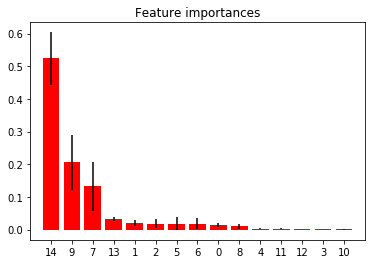

In [8]:
# Check feature importance from ideal model - return to 80/20 train test split
dt_train, dt_test = train_test_split(dt_input, random_state=1,test_size=0.2)
dt_train['spc_common'] = dt_train['spc_common'].map(target_dict)
dt_test['spc_common'] = dt_test['spc_common'].map(target_dict)
x_train = dt_train.drop(['zipcode','Fall','address'],axis=1)
y_train = dt_train.Fall

forest = RandomForestClassifier(n_jobs=-1,class_weight='balanced_subsample',random_state = 1, max_depth = 10, n_estimators = 300)

model = forest.fit(x_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, x_train.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), indices)
plt.xlim([-1, x_train.shape[1]])
plt.show()

Text(0.5, 1.0, '2-class Precision-Recall curve')

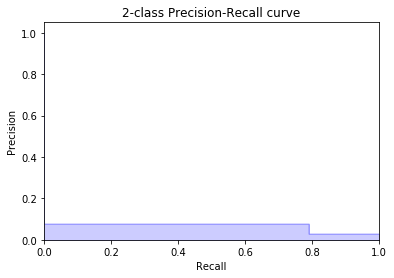

In [13]:
# Check precision recall curve to look at thresholds
from sklearn.metrics import precision_recall_curve
from inspect import signature

precision, recall, _ = precision_recall_curve(y_train, forest.predict(x_train))

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve')

In [25]:
# Check AUC for model on test data
x_test = dt_test.drop(['zipcode','Fall','address'],axis=1)
y_test = dt_test.Fall
y_pred = (forest.predict_proba(x_test)[:,1] >= 0.5).astype(bool)
roc_auc_score(y_test,y_pred)

0.7630665493474108

In [26]:
# Check confusion matrix for model on test data
pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Predicted No Fall', 'Predicted Fall'],
    index=['True No Fall', 'True Fall']
)

,Predicted No Fall,Predicted Fall
True No Fall,113962,39209
True Fall,921,3306


In [27]:
accuracy_score(y_test,y_pred)

0.7450412330525166

In [153]:
# Calculate Fall probabilities of each tree from model
prob_train = forest.predict_proba(x_train)
prob_test = forest.predict_proba(x_test)

In [154]:
# combine all fall probabilites with data
x_train_prob = x_train.copy()
x_test_prob = x_test.copy()
dt_train['fallprob'] = prob_train[:,1]
dt_test['fallprob'] = prob_test[:,1]
data_prob = dt_train.append(dt_test)

C:\Users\Brianne\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Brianne\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


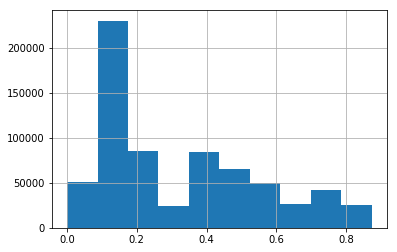

In [158]:
# plot
data_prob.fallprob.hist()


In [159]:
# clean up dataset
data_prob.drop('Fall',axis=1,inplace=True)
data_prob.columns

Index(['tree_id', 'address', 'curb_loc', 'guards', 'health', 'root_grate',
       'root_other', 'root_stone', 'sidewalk', 'spc_common', 'steward',
       'tree_dbh', 'trnk_light', 'trnk_other', 'trnk_wire', 'zipcode',
       'impervious_pct', 'heightroof', 'fallprob'],
      dtype='object')

In [161]:
# export data
data_prob.to_csv('Data/FinalOutputs/NoWarnModelOutput.csv')